In [0]:
import numpy as np
#os hago el trabajo más duro

# Introducción 

La idea de la práctica es visitar aquellos temas que en cierta manera nos permitan ver más contenido del curso.

La práctica esta dividida en 4 o 5 subapartados, que ya tenéis en este mismo Notebook. Estos subapartados estan aquí para que rellenéis el código que hace falta para la realización de la práctica. Obviamente podéis usar tantas celdas como os hagan falta, es más es de agradecer si el código final esta algo "limpio". Usar funciones, algo de comentario, etc, etc...

Usaremos 2 datasets, uno para el primer ejercicio, y otro para el resto de ejercicios.

Ejercicios:


1.   Machine Learning vs Deep Learning (Acordaros que hay que implementar el pipeline visto en clase entero)

    1.1. Implementación de un modelo de Sentiment Analysis con algún algoritmo de Machine Learning Clásico.
    
    1.2. Implementación de un modelo de Sentiment Analysis con alguna arquitectura de Deep Learning.
    
    1.3. Breve Comparación de resultados. Confusion Matrix.
    
2. Hacer Analysis de los tweets del segundo dataset. Que temas aparecen? Como se representan estos temas? De que hablan unos y otros?

3. Escoged a uno de los dos presidentes, y escribid tweets como ellos, usando un Modelo Generativo.

En cada ejercicio, espero explicaciones y razonamientos del porque una arquitectura y no otra, por ejemplo en Deep Learning, porque usar Convolutionals en lugar de recurrentes, o en Machine Learning, Bayes en lugar de SVM. Hay que explicar el pipeline, sobretodo el preproceso de datos, con lo que habrá que hacer un pequeño estudio de que datos tenemos, y si hay cosas que se pueden ignorar, si hacéis stemming, o no, etc, etc...

Acordaros de que objetivo final no es que obtengáis una accuracy brutal, es que comprendais que pasa cuando usais un algoritmo u otro, y que problemas o beneficios nos dan.

![](https://i.pinimg.com/736x/19/63/8c/19638c0b33e2f7822d6806ce31d89d84--funny-cartoons-funny-jokes.jpg)

Mucha suerte y ánimo!



# 1.- Sentiment Analysis Model

Estos primeros puntos son comunes tanto si se utilizan algoritmos de Machine Learning como si son algoritmos de Deep Learning

## 1.1 Librerias

In [0]:
%matplotlib inline

import numpy as np

import pickle
#import json
import os
import csv
import io

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import spacy

from random import sample
from string import punctuation

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## 1.2. Carga de datos - Dataset

Cargo el fichero csv. El nombre del fichero es **train_sentiment.csv**

In [0]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train_sentiment.csv to train_sentiment.csv
User uploaded file "train_sentiment.csv" with length 8664015 bytes


In [0]:
sentiment = pd.read_csv(io.StringIO(uploaded['train_sentiment.csv'].decode('ISO-8859-1')), index_col='ItemID')
sentiment

,Sentiment,SentimentText
ItemID,,
1,0,is so sad for my APL frie...
2,0,I missed the New Moon trail...
3,1,omg its already 7:30 :O
4,0,.. Omgaga. Im sooo im gunna CRy. I'...
5,0,i think mi bf is cheating on me!!! ...
...,...,...
99996,0,@Cupcake seems like a repeating problem hop...
99997,1,@cupcake__ arrrr we both replied to each other...
99998,0,@CuPcAkE_2120 ya i thought so


In [0]:
print ('Tengo ' + str(sentiment.shape [0]) +' tweets, con ' +  str(sentiment.shape [1]) + ' clasificaciones distintas')

Tengo 99989 tweets, con 2 clasificaciones distintas


Estas son las dos clasificaciones que tenemos

In [0]:
set(sentiment.Sentiment.values)

{0, 1}

Visualizando el csv se ve que la clasificación 0 está asociada a un mal sentimiento y la clasificación 1 está asociada a un buen sentimiento

In [0]:
sentiment['Sentiment'].value_counts()

1    56457
0    43532
Name: Sentiment, dtype: int64

In [0]:
print ("Tenemos " + str (sentiment['Sentiment'].value_counts()[1]) + " tweets asociados a buenos sentimientos y " +   
        str (sentiment['Sentiment'].value_counts()[0]) + " tweets asociados a malos sentimientos")

Tenemos 56457 tweets asociados a buenos sentimientos y 43532 tweets asociados a malos sentimientos


## 1.3. Preproceso de datos

- En primer lugar veo que en los textos se utilizam emoticons que tendría que sustitur por su significado. Voy a utilizar esta lista https://en.wikipedia.org/wiki/List_of_emoticons para hacer la traducción de los símbolos. Utilizaré expresiones regulares para la sustitución

In [0]:
def sus_emoticons (frase):
   #Smile :), : ), :‑), :-], :], :-3, :3, :->, :>, 8-), 8), :-}, :}, :o), :c), :^), =], =), (:, ( :, (-:, :')
   frase = re.sub(r'(:\s?\)|:-\)|:-\]|:\]|:-3|:3|:->|:>|8-\)|8\)|:-\}|:\}|:o\)|:c\)|:\^\)|=\]|=\)|\(\s?:|\(-:|:\'\))', 'smile', frase)

   #Laugh :D, : D, :‑D, 8D, 8‑D, xD, x‑D, XD, X‑D, =D, =3, B^D :-)), :'‑), :')
   frase = re.sub(r'(:\s?D|:-D|8-?D|x-?D|X-?D|=D|=3|B\^D|:-+\)|:\'-\))', 'laugh', frase)

   #Sad :‑(, :(, : (,	:‑c, :c, :‑<, :<	:‑[, :[ :-||, >:[, :{	, :@ , >:(, ):, )-:, D‑':,	D:<,	D:,	D8,	D;,	D=,	DX,	
   frase = re.sub(r'(:-\(|:\s?\(|:-c|:c|:-?<|:-?\[|:-\|+|>:\[|:\{|:@|>:\(|\)\s?:|\)-:|D-\':|D:<|D:|D8|D;|D=|DX)', 'sad', frase)
 
   # Cry  :'‑(,:'(,:,(, :'(, :"(
   frase = re.sub(r'(:\'-?\(|:,\(|:\'\(|:"\()', 'cry', frase)

   #Surprise :‑O,:O, :‑o, :o, :-0, 	8‑0, 	>:O
   frase = re.sub(r'(:-?O|:-?o|:-0|8-0|>:O)', 'surprise', frase)

   #Love :-*, :*, :×, <3
   frase = re.sub(r'(:-?\*|:x|<3)', 'love', frase)

   #Wink ;‑), ;), ;-D, ;D, *-), *), ;‑], ;], ;^), :‑, , (;,  (-;
   frase = re.sub(r'(;-?\)|;-?D|\*-?\)|;-?\]|;\^\)|:-,|\(-?;)', 'wink', frase)
   
   #Podría seguir añadiendo más pero creo que con estos se cubren bastantes emociones
   return frase



In [0]:
sentiment['SentimentText'] = sentiment['SentimentText'].apply(lambda t: sus_emoticons(t))

- Convierto a minúsculas

In [0]:
sentiment['SentimentText'] = sentiment['SentimentText'].apply(lambda t: t.lower())

- Quito las URLs

In [0]:
sentiment['SentimentText'] = sentiment['SentimentText'].apply(lambda t: re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', t))

- Voy a quitar también los @nombre de los tweet, usando igualmente una expresión regular

In [0]:
sentiment['SentimentText'] = sentiment['SentimentText'].apply(lambda t: re.sub(r'@[\S]+', '', t))

- Quito los signos de puntuación. Hay algunos símbolos raros que también voy a añadir

In [0]:
signos_p = list(punctuation) + ['“'] + ['”'] + ['—'] + ['✔']+['✓']+['√']
sentiment['SentimentText'] = sentiment['SentimentText'].apply(lambda t: "".join( c for c in t if c not in signos_p))

- Lemmas

In [0]:
nlp = spacy.load('en_core_web_sm')
sentiment['SentimentText'] = sentiment['SentimentText'].apply(lambda x: ' '.join([t.lemma_ for t in nlp(x)]))

- Si me encuentro con varios espacios lo sustituyo por uno solo

In [0]:
sentiment['SentimentText'] = sentiment['SentimentText'].apply(lambda t: re.sub(r'\s+', ' ', t))

- Voy a comprobar si hay algún tweet con valor nan o vacio para eliminarlo

In [0]:
sentiment.dropna(subset=['SentimentText'], inplace=True)
sentiment = sentiment.loc[sentiment['SentimentText']!='']

No voy a eliminar las stopword. No es recomendable para el análisis de sentimientos (se elimina por ejemplo palabras como "no")

## 1.4. Machine Learning

Es un problema de clasificación. Voy a utilizar dos algoritmos de machinle learning: Bayes y SVM. Además voy a utilizar pipeline para escoger los mejores parámetros tanto para la extración de características como para la clasificación

Nota: Las dos siguientes celdas se utiliza si queremos cargar directamente el fichero "sentiment_cleaned.csv" que es resultado de todo el preproceso anterior. Hay algún paso como el de lemmas que tarda un poco. Si venimos ejecutando lo puntos anteriores podemos saltarnos las dos celdas siguientes

In [0]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving sentiment_cleaned.csv to sentiment_cleaned.csv
User uploaded file "sentiment_cleaned.csv" with length 7360419 bytes


In [0]:
sentiment = pd.read_csv(io.StringIO(uploaded['sentiment_cleaned.csv'].decode('ISO-8859-1')), index_col='ItemID')


Primero dividio en train y test

In [0]:
X = sentiment['SentimentText']
y = sentiment['Sentiment']  #variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)

###1.4.1 Algoritmo: Naive Bayes

Creo el pipeline

In [0]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),    #Extracción de features
    ('clf', MultinomialNB()),       #MultinomialNB, clasificador
])

pipeline.get_params()        #Para ver todos los posibles parámetros

{'clf': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
         

Defino los parámetros a optimizar con unos rangos para el GridSearch

In [0]:
parameters = {
    'vect__min_df': (2, 3),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 3), (1,4)),
    'clf__alpha': (1e-1, 1e-2, 1e-3),
}

GridSearch para encontrar los mejores parámetros

In [0]:
gs=GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)  

In [0]:
gs.fit(X_train, y_train)
best_parameters = gs.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % gs.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 23.9min finished


	clf__alpha: 0.1
	vect__max_df: 0.75
	vect__min_df: 3
	vect__ngram_range: (1, 4)
Best score: 0.756


Aplicamos los mejores parámetros extraidos con el GridSearch

In [0]:
pipeline.set_params(**best_parameters)
scoring = pipeline.score(X_test, y_test)
print('Test Score: {}'.format(scoring))

Test Score: 0.7586258625862586


Obtengo un 75.86%

Alguna prueba para ver el funcionamiento:

In [0]:
pipeline.predict(["I'm cold, too bad!"])   #Mal

array([0])

In [0]:
pipeline.predict(["Tomorrow I'll go on trip. I am very excited"])  #Bien

array([1])

Matriz de Confusión

In [0]:
#Función para representar la matriz de confusión
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [0]:
#Función para cálculo de métricas
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    

In [0]:
y_pred = pipeline.predict (X_test)
y_test = np.array(list(y_test))

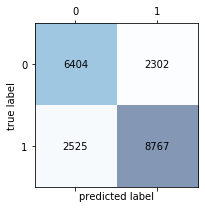

ACC:  0.7586258625862586
SEN:  0.776390364860078
ESP:  0.7355846542614289
PPV:  0.7920318005239859
FSC:  0.7841330888600689


In [0]:
confmat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat)
calcula_metricas(confmat)

###1.4.2 Algoritmo: Support Vector Machines

Creo el pipeline

In [0]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),                             #Extracción de features
    ('clf', LinearSVC()),                                    #SVC, clasificador
])
pipeline.get_params()        #Para ver todos los posibles parámetros

{'clf': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0),
 'clf__C': 1.0,
 'clf__class_weight': None,
 'clf__dual': True,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__loss': 'squared_hinge',
 'clf__max_iter': 1000,
 'clf__multi_class': 'ovr',
 'clf__penalty': 'l2',
 'clf__random_state': None,
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabul

Defino los parámetros para el GridSearch

In [0]:
parameters = {
    'vect__min_df': (2, 3),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 3), (1,4)),
    'clf__C': (0.1, 0.5, 1),
}

GridSearch para encontrar los mejores parámetros

In [0]:
gs=GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)  

In [0]:
gs.fit(X_train, y_train)
best_parameters = gs.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % gs.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 53.5min finished


	clf__C: 0.1
	vect__max_df: 0.75
	vect__min_df: 2
	vect__ngram_range: (1, 3)
Best score: 0.767


Aplicamos los mejores parámetros extraidos con el GridSearch

In [0]:
pipeline.set_params(**best_parameters)
scoring = pipeline.score(X_test, y_test)
print('Test Score: {}'.format(scoring))

Test Score: 0.7632263226322632


Obtengo un 76.32% . Con SVC consigo mejorar un poquito el resultado de Bayes pero podemos decir que ambos nos están dando un resultado parecido

Matriz de Confusión

In [0]:
y_pred = pipeline.predict (X_test)
y_test = np.array(list(y_test))

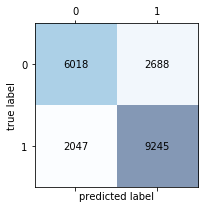

ACC:  0.7632263226322632
SEN:  0.8187212185618137
ESP:  0.6912474155754652
PPV:  0.7747423112377441
FSC:  0.7961248654467169


In [0]:
confmat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat)
calcula_metricas(confmat)

## 1.5. Deep Learning

Es un problema de clasificación. Voy a utilizar varios modelos: DAN, CNN, RNN y BiLSTM.
 
La étapa de preprocesamiento es la misma que en Machine Learning por lo que partimos del mismo punto. El pipeline varía con respecto al de Machine Learning en el diseño del modelo, donde hay que tener en cuenta que hay que añadir word embeddings en el proceso

Nota: Las dos siguientes celdas se utiliza si queremos cargar directamente el fichero "sentiment_cleaned.csv" que es resultado de todo el preproceso anterior. Hay algún paso como el de lemmas que tarda un poco. Si venimos ejecutando lo puntos anteriores podemos saltarnos las dos celdas siguientes

In [0]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving sentiment_cleaned.csv to sentiment_cleaned.csv
User uploaded file "sentiment_cleaned.csv" with length 7360419 bytes


In [0]:
sentiment = pd.read_csv(io.StringIO(uploaded['sentiment_cleaned.csv'].decode('ISO-8859-1')), index_col='ItemID')

In [0]:
#Función para dividir en train y test
def split_train_val_test(dataset, split=0.2):

    x, y = zip(*dataset)
    x = np.array(list(x))
    y = np.array(list(y))
    sss = StratifiedShuffleSplit(n_splits=1, test_size=split, random_state=1234) 
    for train_index, test_index in sss.split(x, y):
        x_train, x_val = x[train_index], x[test_index]
        y_train, y_val = y[train_index], y[test_index]
    splits = {'train':(x_train, y_train), 'test':(x_val, y_val)}
    return splits

### 1.5.1- Preproceso

In [0]:
dataset = []
for row in sentiment.iterrows():
  ix, data = row
  dataset.append((data[1], data[0])) #Me preparo en el dataset X e y. 

Tokenizado y vocabulario

In [0]:
from collections import Counter
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner', 'textcat'])
tokens = []    #lista con todos los tokens que hay en el dataset
tokenized = [] #lista con tuplas (documento_tokenizado, etiqueta)
for x, y in dataset:
  x_t = nlp(x)
  toks = [t.text for t in x_t] #tokenizo las frases
  tokens += toks
  tokenized.append((toks, y)) #Me creo un dataset con las frases tokenizadas y mantengo el target

vocab_counter = Counter (tokens)
vocab = set (tokens) #Palabras únicas que tengo
print ('Num de features a usar: ', len(vocab))
print (len(tokenized))  

Num de features a usar:  60874
99989


Exploro las longitudes de las frases

In [0]:
maxlen = max([len(x) for x, _ in tokenized])
print ("Máximo número de palabras en una frase " + str (maxlen))

182

Calculo la media y la mediana de palabras en una frase y establezco que el nuevo máximo de palabras en una frase sea el doble de la mediana

In [0]:
lens = [len(x) for x, _ in tokenized]
median = np.median (np.array(lens))
mean = np.mean(np.array (lens))
maxlen = int(median)*2        #defino un nuevo máximo como el doble de la mediana
print (median, mean, maxlen)

13.0 13.574633209653062 26


Borro todas las frases que tengan mayor longitud que el nuevo máximo establecido. Posteriormente veré cuantas frases me quedan y comprobaré si hemos eliminado muchas frases o no para retocar, caso de ser necesario, este nuevo máximo

In [0]:
#La media y la mediana son de 13 palabras en la frase. Me puedo quedar con el nuevo maxlen = 26
# borro todas las frases de más de 26 
tokenized_filtered = [(x,y) for x,y in tokenized if len(x)<maxlen]
len(tokenized_filtered)

94042

Veo que he pasado de tener 99989 a 94042. Lo dejo así ya que no he perdido muchas frases

Construyo ahora el vocabulario y añado en última posición el token UNK que se utilizará cuando nos llegue una palabra que no esté en el vocabulario

In [0]:
#Construyo el vocabulario
w2id = {k:i for i,k in enumerate(vocab)}
w2id['<UNK>'] = len(w2id)  #Al vocabulario le añado un <UNK> para cuando nos llegue una palabra 
                           #que no esté en nuestro vocabulario

### 1.5.2- Padding + Input preparation

In [0]:
#Etiquetas, para hacer one-hot de las labels
labels = ['Malo','Bueno']
l2id = {label:i for i, label in enumerate(labels)}

In [0]:
l2id

{'Bueno': 1, 'Malo': 0}

Preparar Input. Padding. Conversión a input

In [0]:
  sentence = np.zeros((maxlen)) 
  label = np.zeros((len(labels)))
  label[int(y)-1]=1   
  for i, t in enumerate(x):
    sentence[i]=w2id[t] if t in vocab_counter and vocab_counter[t]>=3 else w2id['<UNK>'] #Transformo la frase en indíces, relleno el vector posición a posición
    #para hacerlo más real considero que las palabras que han aparecido menos de 3 veces son <UNK>, no han aparecido nunca  
  input_ready.append ((sentence, label))   

In [0]:
input_ready[0][0].shape   #Compruebo la longitud de las frases

(26,)

Separo en train y test

In [0]:
splits = split_train_val_test (input_ready)
print (splits['train'][0].shape)   
print (splits['train'][1].shape)
splits['train'][1] #Para visualizar la variable y - target

(75233, 26)
(75233, 2)


array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

### 1.5.3- Modelo Deep Averaging Networks - DAN

Este modelo tiene una arquitectura muy simple pero funciona bien para clasificación: cogemos embeddings, hacemos un average de ellos, y lo pasamos por un par de capas. 

In [0]:
from keras.layers import Input, Average, average, Lambda
from keras.models import Model
from keras.layers import Embedding, Dense, Dropout


from keras import backend as K

Creación de Lambda Custom

In [0]:
def mask_aware_mean(x):
    #Si el vector contiene todo 0 no le haré la media
    mask = K.not_equal (K.sum(K.abs(x), axis=2, keepdims=True), 0) #me genera una máscara donde marca todas las filas con todo a 0

    n = K.sum(K.cast(mask, 'float32'), axis=1, keepdims=False) #Suma los embedding que no sean cero
    x_mean = K.sum (x, axis=1, keepdims=False) /n
    return x_mean
    

def mask_aware_mean_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3, 'Dimensions for average are wrong'
    return (shape[0], shape[2])

Modelo

In [0]:
input_layer = Input (shape=(maxlen,))
embedding = Embedding(output_dim=300, input_dim=len(w2id), input_length=maxlen, name='m_embedding')(input_layer) 
#La función Lambda me permite crear capas personalizadas
doc_representation = Lambda (mask_aware_mean, mask_aware_mean_output_shape, name='embedding_average')(embedding)
dense_1 = Dense (300, activation='relu')(doc_representation)
drop_1 = Dropout (0.5) (dense_1)
dense_2 = Dense (300, activation='relu')(drop_1)
drop_2 = Dropout (0.5) (dense_2)
out = Dense (len(l2id), activation='softmax')(drop_2)  #Clasifico en 0 ó 1

model = Model (inputs=input_layer, outputs = out )
model.compile (loss='categorical_crossentropy',
               optimizer='rmsprop',
               metrics = ['accuracy']
               )
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 26)                0         
_________________________________________________________________
m_embedding (Embedding)      (None, 26, 300)           18262500  
_________________________________________________________________
embedding_average (Lambda)   (None, 300)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_29 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_30 (Dropout)         (None, 300)               0  

Entrenamiento. Utilizo 5 épocas. He visto que si entrenamos más épocas empieza a haber overfitting

In [0]:
model.fit (splits['train'][0], splits['train'][1], validation_split=0.2,
           epochs=5,
           batch_size=16)

Train on 60186 samples, validate on 15047 samples
Epoch 1/5
60186/60186 [==============================] - 34s 569us/step - loss: 0.5413 - acc: 0.7303 - val_loss: 0.5080 - val_acc: 0.7439
Epoch 2/5
60186/60186 [==============================] - 32s 538us/step - loss: 0.5112 - acc: 0.7600 - val_loss: 0.5121 - val_acc: 0.7582
Epoch 3/5
60186/60186 [==============================] - 32s 533us/step - loss: 0.5076 - acc: 0.7650 - val_loss: 0.4985 - val_acc: 0.7593
Epoch 4/5
60186/60186 [==============================] - 32s 537us/step - loss: 0.5043 - acc: 0.7675 - val_loss: 0.5065 - val_acc: 0.7548
Epoch 5/5
60186/60186 [==============================] - 32s 535us/step - loss: 0.5038 - acc: 0.7707 - val_loss: 0.5058 - val_acc: 0.7553


In [0]:
score_basic=model.evaluate(splits['test'][0], splits['test'][1], batch_size=16)
score_basic

18809/18809 [==============================] - 2s 88us/step


[0.517683408502009, 0.748418310389665]

Obtengo un 74.84%

Matriz de confusión

In [0]:
#Función para transformar y_pred y que tenga solo valores a 0 ó 1
def Transforma_y_pred (y_pred):
   for lin in range (len(y_pred)):
      if y_pred[lin][0] > y_pred[lin][1]:
         y_pred[lin][0] = 1
         y_pred[lin][1] = 0
      else:
         y_pred[lin][0] = 0
         y_pred[lin][1] = 1
   return y_pred 

In [0]:
#Calculamos la predicción
y_pred = model.predict(splits['test'][0])
y_pred = y_pred = Transforma_y_pred (y_pred)
y_test = splits['test'][1]


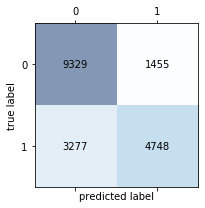

ACC:  0.7484183103833272
SEN:  0.5916510903426792
ESP:  0.8650778931750742
PPV:  0.7654360793164597
FSC:  0.6674163621028957


In [0]:
#Cálculo de la matriz de confusión
confmat = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
plot_confusion_matrix(confmat)
calcula_metricas(confmat)

### 1.5.4- Modelo Convolutional Neural Networks para Texto - CNN

Utilizo ahora un modelo con 3 capas convolucionales y una MaxPooling tras cada capa convolucional, terminado finalmente con 3 capas densas y Dropout para introducir regularización

In [0]:
from keras.layers import GlobalMaxPooling2D, Concatenate
from keras.layers import Concatenate, Reshape, Conv2D

Modelo

In [0]:
embedding_dim=100

input_layer = Input (shape=(maxlen,))

embedding = Embedding(output_dim=100, input_dim=len(w2id), input_length=maxlen, name='m_embedding')(input_layer) 

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)
#el kernel lo fijamos con la dimensión del embedding
conv_1 = Conv2D (filters=50, kernel_size=(1, embedding_dim), activation='relu', padding='valid')(reshape)
mp_1 = GlobalMaxPooling2D()(conv_1)

conv_2 = Conv2D (filters=50, kernel_size=(2, embedding_dim), activation='relu', padding='valid')(reshape)
mp_2 = GlobalMaxPooling2D()(conv_2)

conv_5 = Conv2D (filters=50, kernel_size=(5, embedding_dim), activation='relu', padding='valid')(reshape)
mp_5 = GlobalMaxPooling2D()(conv_5)

doc_representation = Concatenate ()([mp_1, mp_2, mp_5]) 


dense_1 = Dense (100, activation='relu')(doc_representation)
drop_1 = Dropout (0.5) (dense_1)
dense_2 = Dense (100, activation='relu')(drop_1)
drop_2 = Dropout (0.5) (dense_2)
out = Dense (len(l2id), activation='softmax')(drop_2)

In [0]:
model = Model (inputs=input_layer, outputs = out )
model.compile (loss='categorical_crossentropy',
               optimizer='rmsprop',
               metrics = ['accuracy']
               )
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 26)           0                                            
__________________________________________________________________________________________________
m_embedding (Embedding)         (None, 26, 100)      6087500     input_19[0][0]                   
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 26, 100, 1)   0           m_embedding[0][0]                
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 26, 1, 50)    5050        reshape_2[0][0]                  
___________________________________________________________________________________________

Entrenamiento: Utilizo 5 épocas. He visto que si entrenamos más épocas empieza a haber overfitting

In [0]:
model.fit (splits['train'][0], splits['train'][1],validation_split=0.2,
           epochs=5,
           batch_size=16)

Train on 60186 samples, validate on 15047 samples
Epoch 1/5
60186/60186 [==============================] - 29s 486us/step - loss: 0.5369 - acc: 0.7336 - val_loss: 0.4950 - val_acc: 0.7600
Epoch 2/5
60186/60186 [==============================] - 27s 448us/step - loss: 0.4963 - acc: 0.7715 - val_loss: 0.5135 - val_acc: 0.7665
Epoch 3/5
60186/60186 [==============================] - 27s 448us/step - loss: 0.4888 - acc: 0.7855 - val_loss: 0.5327 - val_acc: 0.7624
Epoch 4/5
60186/60186 [==============================] - 27s 448us/step - loss: 0.4864 - acc: 0.7933 - val_loss: 0.5460 - val_acc: 0.7657
Epoch 5/5
60186/60186 [==============================] - 27s 448us/step - loss: 0.4895 - acc: 0.7984 - val_loss: 0.5134 - val_acc: 0.7687


In [0]:
score_basic=model.evaluate(splits['test'][0], splits['test'][1], batch_size=16)
score_basic

18809/18809 [==============================] - 2s 96us/step


[0.5231526264372901, 0.7667605933361479]

Obtengo un 76.67%

Matriz de confusión

In [0]:
#Calculamos la predicción
y_pred = model.predict(splits['test'][0])
y_pred = y_pred = Transforma_y_pred (y_pred)
y_test = splits['test'][1]

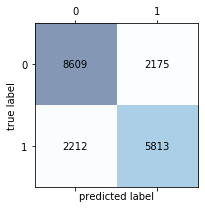

ACC:  0.7667605933329789
SEN:  0.7243613707165109
ESP:  0.7983123145400594
PPV:  0.7277165748622935
FSC:  0.7260350964841068


In [0]:
confmat = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
plot_confusion_matrix(confmat)
calcula_metricas(confmat)

### 1.5.5- Modelo Recurrent Neural Network para texto - RNN

Probamos ahora con un modelo Recurrent Neural Network para introducir el concepto de serie temporal, es decir, que cada palabra va a depender del pasado. Usaremos como tipo de rnn la CuDNNLSTM que corre sobre la GPU y por tanto es la más rápida

In [0]:
from keras.layers import LSTM, SimpleRNN, CuDNNLSTM  #La última es la más rápida, va solo sobre GPU

In [0]:
tipo_rnn = CuDNNLSTM(100)

Modelo

In [0]:
input_layer = Input(shape=(maxlen,))
embedding = Embedding(output_dim=100, input_dim=len(w2id), input_length=maxlen, name='m_embedding')(input_layer)

#Esto es lo que cambia. Representación del documento
doc_representation = tipo_rnn(embedding)

dense_1 = Dense(100, activation='relu')(doc_representation)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(100, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(len(l2id), activation='softmax')(drop_2)

model = Model(inputs=input_layer, outputs=out)
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 26)                0         
_________________________________________________________________
m_embedding (Embedding)      (None, 26, 100)           6087500   
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 100)               80800     
_________________________________________________________________
dense_48 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_34 (Dropout)         (None, 100)               0  

Entrenamiento: Utilizo 5 épocas. He visto que si entrenamos más épocas empieza a haber overfitting

In [0]:
model.fit(splits['train'][0], splits['train'][1],validation_split=0.2, 
          epochs=5, batch_size=16)

Train on 60186 samples, validate on 15047 samples
Epoch 1/5
60186/60186 [==============================] - 30s 499us/step - loss: 0.5511 - acc: 0.7253 - val_loss: 0.5136 - val_acc: 0.7593
Epoch 2/5
60186/60186 [==============================] - 28s 469us/step - loss: 0.4962 - acc: 0.7665 - val_loss: 0.4876 - val_acc: 0.7642
Epoch 3/5
60186/60186 [==============================] - 28s 461us/step - loss: 0.4684 - acc: 0.7861 - val_loss: 0.4942 - val_acc: 0.7697
Epoch 4/5
60186/60186 [==============================] - 28s 465us/step - loss: 0.4529 - acc: 0.7953 - val_loss: 0.4802 - val_acc: 0.7732
Epoch 5/5
60186/60186 [==============================] - 28s 467us/step - loss: 0.4410 - acc: 0.8034 - val_loss: 0.4850 - val_acc: 0.7729


In [0]:
score_basic=model.evaluate(splits['test'][0], splits['test'][1], batch_size=16)
score_basic

18809/18809 [==============================] - 3s 134us/step


[0.49160078250783196, 0.773512680109459]

Obtengo un resultado de 77.35%

Matriz de confusión

In [0]:
#Calculamos la predicción
y_pred = model.predict(splits['test'][0])
y_pred = y_pred = Transforma_y_pred (y_pred)
y_test = splits['test'][1]

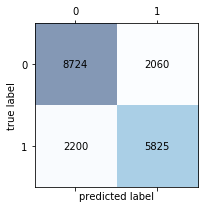

ACC:  0.7735126800999521
SEN:  0.7258566978193146
ESP:  0.8089762611275965
PPV:  0.7387444514901712
FSC:  0.7322438717787556


In [0]:
confmat = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
plot_confusion_matrix(confmat)
calcula_metricas(confmat)

### 1.5.6- Modelo BiLSTM

Las redes de tipo LSTM son un caso especial de las RNN. Son capaces de guardar información entre dependencias más largas. Las celdas LSTMs tiene 3 pasos, que queremos olvidar, que queremos aprender, y que queremos mostrar. Una BiLSTM es una arquitectura algo especial. Son Bidireccionales

In [0]:
from keras.layers import Bidirectional

Modelo:

In [0]:
tipo_rnn = CuDNNLSTM(100)
input_layer = Input(shape=(maxlen,))
embedding = Embedding(output_dim=100, input_dim=len(w2id), input_length=maxlen, name='m_embedding')(input_layer)

doc_representation = Bidirectional(tipo_rnn)(embedding)

dense_1 = Dense(100, activation='relu')(doc_representation)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(100, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(len(l2id), activation='softmax')(drop_2)

model = Model(inputs=input_layer, outputs=out)
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 26)                0         
_________________________________________________________________
m_embedding (Embedding)      (None, 26, 100)           6087500   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 200)               161600    
_________________________________________________________________
dense_51 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_35 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_36 (Dropout)         (None, 100)               0  

Entrenamiento: Utilizo 5 épocas. He visto que si entrenamos más épocas empieza a haber overfitting

In [0]:
model.fit(splits['train'][0], splits['train'][1],validation_split=0.2, 
          epochs=5, batch_size=16)

Train on 60186 samples, validate on 15047 samples
Epoch 1/5
60186/60186 [==============================] - 37s 622us/step - loss: 0.5439 - acc: 0.7268 - val_loss: 0.5106 - val_acc: 0.7401
Epoch 2/5
60186/60186 [==============================] - 35s 580us/step - loss: 0.4884 - acc: 0.7721 - val_loss: 0.5253 - val_acc: 0.7631
Epoch 3/5
60186/60186 [==============================] - 35s 580us/step - loss: 0.4666 - acc: 0.7917 - val_loss: 0.4834 - val_acc: 0.7746
Epoch 4/5
60186/60186 [==============================] - 36s 592us/step - loss: 0.4550 - acc: 0.8021 - val_loss: 0.4951 - val_acc: 0.7766
Epoch 5/5
60186/60186 [==============================] - 35s 579us/step - loss: 0.4432 - acc: 0.8092 - val_loss: 0.5344 - val_acc: 0.7726


In [0]:
score_basic=model.evaluate(splits['test'][0], splits['test'][1], batch_size=16)
score_basic

18809/18809 [==============================] - 3s 175us/step


[0.5377714210301535, 0.7709607103014304]

Obtengo un resultado de 77.10 %

Matriz de confusión:

In [0]:
#Calculamos la predicción
y_pred = model.predict(splits['test'][0])
y_pred = y_pred = Transforma_y_pred (y_pred)
y_test = splits['test'][1]

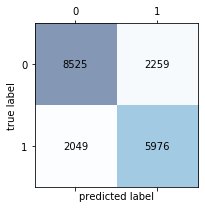

ACC:  0.7709607102982615
SEN:  0.7446728971962617
ESP:  0.790522997032641
PPV:  0.7256830601092896
FSC:  0.7350553505535056


In [0]:
confmat = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
plot_confusion_matrix(confmat)
calcula_metricas(confmat)

### 1.5.6- Modelo BiLSTM con vectores pre-entrenados de Glove para la capa embeddings

En este enlace tenemos vectores preentrenados de Glove para Twitter: https://nlp.stanford.edu/projects/glove/

En esta página he consultado como usar word embeddings pre-entrenados en Keras: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

Me bajo los vectores preentrenados de Glove

In [0]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip

--2020-02-17 15:27:11--  http://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip [following]
--2020-02-17 15:27:11--  https://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.twitter.27B.zip [following]
--2020-02-17 15:27:12--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting respon

Descomprimo

In [0]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


Cargo el embedding como un diccionario

In [0]:
embeddings_index = {}
f = open('glove.twitter.27B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193515 word vectors.


Construyo la matriz embedding

In [0]:

embedding_matrix = np.zeros((len(w2id), 100))
for word, i in w2id.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Modelo. Cargo la matriz anterior en la capa Embedding

In [0]:
tipo_rnn = CuDNNLSTM(100)
input_layer = Input(shape=(maxlen,))
embedding = Embedding(output_dim=100, input_dim=len(w2id), input_length=maxlen,
                      weights=[embedding_matrix], trainable=False, name='m_embedding')(input_layer)
#trainable=False evitamos que los pesos se actualicen durante el entrenamiento
doc_representation = Bidirectional(tipo_rnn)(embedding)

dense_1 = Dense(100, activation='relu')(doc_representation)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(100, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(len(l2id), activation='softmax')(drop_2)

model = Model(inputs=input_layer, outputs=out)
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 26)                0         
_________________________________________________________________
m_embedding (Embedding)      (None, 26, 100)           6087500   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 200)               161600    
_________________________________________________________________
dense_54 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_37 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_38 (Dropout)         (None, 100)               0  

Entrenamiento:

In [0]:
model.fit(splits['train'][0], splits['train'][1],validation_split=0.2, 
          epochs=5, batch_size=16)

Train on 60186 samples, validate on 15047 samples
Epoch 1/5
60186/60186 [==============================] - 32s 524us/step - loss: 0.5446 - acc: 0.7233 - val_loss: 0.5059 - val_acc: 0.7610
Epoch 2/5
60186/60186 [==============================] - 29s 486us/step - loss: 0.5023 - acc: 0.7611 - val_loss: 0.4701 - val_acc: 0.7730
Epoch 3/5
60186/60186 [==============================] - 29s 488us/step - loss: 0.4908 - acc: 0.7713 - val_loss: 0.4784 - val_acc: 0.7715
Epoch 4/5
60186/60186 [==============================] - 30s 496us/step - loss: 0.4845 - acc: 0.7798 - val_loss: 0.5308 - val_acc: 0.7693
Epoch 5/5
60186/60186 [==============================] - 29s 481us/step - loss: 0.4730 - acc: 0.7846 - val_loss: 0.4834 - val_acc: 0.7740


In [0]:
score_basic=model.evaluate(splits['test'][0], splits['test'][1], batch_size=16)
score_basic

18809/18809 [==============================] - 3s 175us/step


[0.49776316529807435, 0.7679834122057958]

Obtengo un resultado de 76.80%

Matriz de confusión

In [0]:
#Calculamos la predicción
y_pred = model.predict(splits['test'][0])
y_pred = y_pred = Transforma_y_pred (y_pred)
y_test = splits['test'][1]

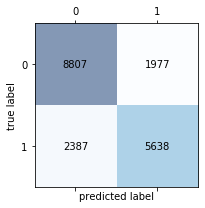

ACC:  0.767983412196289
SEN:  0.7025545171339563
ESP:  0.8166728486646885
PPV:  0.7403808273145108
FSC:  0.7209718670076726


In [0]:
confmat = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
plot_confusion_matrix(confmat)
calcula_metricas(confmat)

## 1.6.- Comparación de resultados

Modelos Machine Learning:

- Bayes:  75.86%
- SVC:    76.32%

Modelos de Deep Learning:

- DAN:    74.84%
- CNN:    76.67%
- RNN:    77.35%
- BiLSTM: 77.10 %
- BiLSTM con Glove Preentrenado: 76.80%

Los modelos que dan mejores resultados son los de Deep Learning, en concreto los del tipo **RNN** y **BiLSTM**. De todas formas las prestaciones son muy parecidas en todos los modelos y quizás por simplicidad me podría quedar con el modelo SVC de Machine Learning.

# 2.- *Tweet* Analysis

Esta problemática se encuadra dentro del aprendizaje no superviado y en concreto dentro de Topic Modeling

Usaré el algoritmo  Latent Dirichlet Allocation - LDA. 




## 2.1.- Librerías

In [0]:
!pip install gensim  
!pip install pyLDAvis
!pip install stop_words

     |████████████████████████████████| 1.6MB 15.2MB/s 
     |████████████████████████████████| 552kB 52.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=09915ad84d3850dedb32243e200c20bfd950e2a5d9d5f037d784b5a22a045505
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=6419dbc13335ad5917014c3ff14c5fe105374a11d955e085901c3020c931cf38
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32917 sha256=2bce69cebd33c879fcf63a1d3cf79b6daa269cfbd7a7536bb17e2a37d1e01b3d
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [0]:
import gensim
from os.path import join
import spacy
from stop_words import get_stop_words
from string import punctuation
import re
import numpy as np
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import pandas as pd
import io
import json

import warnings
warnings.filterwarnings('ignore')





## 2.2. Carga de datos

Cargo el fichero json. El nombre del fichero es **datset_2.json**

In [0]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dataset_2.json to dataset_2.json
User uploaded file "dataset_2.json" with length 1070528 bytes


Visualizo como vienen los datos

In [0]:
json_twitter = json.loads (uploaded['dataset_2.json'])
json_twitter 

{'0': {'label': 'OBAMA',
  'tweet': '“Low plastic stool, cheap but delicious noodles, cold Hanoi beer.” This is how I’ll remember Tony. He taught us about food — but more importantly, about its ability to bring us together. To make us a little less afraid of the unknown. We’ll miss him. https://t.co/orEXIaEMZM'},
 '1': {'label': 'OBAMA',
  'tweet': '“Low plastic stool, cheap but delicious noodles, cold Hanoi beer.” This is how I’ll remember Tony. He taught us about food — but more importantly, about its ability to bring us together. To make us a little less afraid of the unknown. We’ll miss him. https://t.co/orEXIaEMZM'},
 '2': {'label': 'OBAMA',
  'tweet': 'This National Gun Violence Awareness Day, show your commitment to keeping our kids safe from gun violence. Then, for everyone we’ve lost, take action to change our leadership and our laws until they reflect that commitment - no matter how long it takes. https://t.co/lraIwlQAgl'},
 '3': {'label': 'OBAMA',
  'tweet': 'We can never tr

Construyo el dataset. Viendo como vienen los datos uso orient='index' para cargarlos

In [0]:
twitters = pd.read_json('dataset_2.json', orient='index')
twitters.head(5)

,label,tweet
0,OBAMA,"“Low plastic stool, cheap but delicious noodle..."
1,OBAMA,"“Low plastic stool, cheap but delicious noodle..."
10,OBAMA,Michelle and I are so inspired by all the youn...
100,OBAMA,Senate leaders' obstruction of our Supreme Cou...
1000,OBAMA,"In 31 states, people can still be fired becaus..."


In [0]:
print ('Tengo ' + str(twitters.shape [0]) +' tweets, con ' +  str(twitters.shape [1]) + ' labels distintas')

Tengo 5889 tweets, con 2 labels distintas


Averiguo cuales son  las dos labes que tengo:

In [0]:
set(twitters.label.values)

{'OBAMA', 'TRUMP'}

Veamos cuantos tweet de cada presidente hay

In [0]:
twitters['label'].value_counts()

TRUMP    2995
OBAMA    2894
Name: label, dtype: int64

Tenemos aproximadamente los mismos de uno y otro presidente.

## 2.3.- Preproceso de datos

Voy a añadir una columna al dataset que se va a llamar "twitter_procesado" en la que voy a ir aplicando las diferentes transformaciones

- En primer lugar paso todo a minúsculas

In [0]:
twitters['twitter_procesado'] = twitters['tweet'].apply(lambda t: t.lower())

- Veo que hay URLs. En este caso, como lo que estoy intentando averiguar es de que temas hablan, las URLs no me aportan información así que las voy a eliminar. Utilizo para ello una expresión regular

In [0]:
twitters['twitter_procesado'] = twitters['twitter_procesado'].apply (lambda t: re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', t))

- Voy a quitar también los @nombre de los tweet, usando igualmente una expresión regular

In [0]:
twitters['twitter_procesado'] = twitters['twitter_procesado'].apply(lambda t: re.sub(r'@[\S]+', '', t))

- Quito los signos de puntuación. Hay algunos símbolos raros que también voy a añadir

In [0]:
signos_p = list(punctuation) + ['“'] + ['”'] + ['—'] + ['✔']+['✓']+['√']
twitters['twitter_procesado'] = twitters['twitter_procesado'].apply(lambda t: "".join( c for c in t if c not in signos_p))

- Elimino las Stop Words

In [0]:
stop_words = get_stop_words('en')
twitters['twitter_procesado'] = twitters['twitter_procesado'].apply(lambda t: " ".join(t for t in t.split() if t not in stop_words))

- Lemmas

In [0]:
nlp = spacy.load('en_core_web_sm')
twitters['twitter_procesado'] = twitters['twitter_procesado'].apply(lambda x: ' '.join([t.lemma_ for t in nlp(x)]))


- Si me encuentro con varios espacios los sustituyo por uno solo

In [0]:
twitters['twitter_procesado'] = twitters['twitter_procesado'].apply(lambda t: re.sub(r'\s+', ' ', t))

- Voy a comprobar si hay algún tweet con valor nan o vacío para eliminarlo si es así

In [0]:
tweetna =twitters.tweet.isna().sum ()
tweetna 

0

In [0]:
#En este caso no hay nulos pero si los hubiera los eliminaríamos así:
twitters.dropna(subset=['tweet'], inplace=True)

In [0]:
#Si hay alguno vacio lo elimino
twitters = twitters.loc[twitters['twitter_procesado']!='']

In [0]:
twitters.head(5)

,label,tweet,twitter_procesado
0,OBAMA,"“Low plastic stool, cheap but delicious noodle...",low plastic stool cheap delicious noodle cold ...
1,OBAMA,"“Low plastic stool, cheap but delicious noodle...",low plastic stool cheap delicious noodle cold ...
10,OBAMA,Michelle and I are so inspired by all the youn...,michelle inspire young people make today ’s ma...
100,OBAMA,Senate leaders' obstruction of our Supreme Cou...,senate leader obstruction supreme court nomina...
1000,OBAMA,"In 31 states, people can still be fired becaus...",31 state people can still fire love help chang...


Tras el procesado elimino la columna tweet que no me hace mas falta y guardo el dataset ya procesado por si hicera falta posteriormente

In [0]:
twitters.drop ('tweet', axis=1, inplace=True)

In [0]:
twitters.head(5)

,label,twitter_procesado
0,OBAMA,low plastic stool cheap delicious noodle cold ...
1,OBAMA,low plastic stool cheap delicious noodle cold ...
10,OBAMA,michelle inspire young people make today ’s ma...
100,OBAMA,senate leader obstruction supreme court nomina...
1000,OBAMA,31 state people can still fire love help chang...


In [0]:
twitters_procesado = twitters.to_csv('twitters_procesado.csv', index=id, header=True)

## 2.4.- Topic Modeling

Preparo primero el dataset

In [0]:
documents = []

for row in twitters.iterrows():   #va recorriendo todas las filas del df
    _,info = row          #en info se queda con el Sendador, Answer y Respuesta. No se queda con el índice (_)         
    _,tweet = info
    tweet = re.sub(r'\n', '', tweet)
    #tokenizo 
    tweet = [t.text for t in nlp(tweet.rstrip(), disable=['parser', 'tagger', 'ner'])]
    #Lo juntamos todo en un mismo corpus
    documents.append(tweet)
    

In [0]:
#Vocabulario
vocab = set([t for doc in documents for t in doc])

w2id = {k:i for i, k in enumerate(vocab)}
id2w = {i:k for k, i in w2id.items()}

'unique tokens {}'.format(len(w2id))

'unique tokens 7291'

### 2.4.1.-Implementación usando Gensim. Modelo LDA 

Voy a separar en 2 topics para comprobar si los dos presidentes hablan de temas diferentes

In [0]:
from gensim import corpora, models, similarities
from math import exp
from gensim.corpora import Dictionary

In [0]:
#Crea el vocabulario/diccionario 
gensim_dict = Dictionary(documents)
len(gensim_dict)  #Veo que me da el mismo resultado que se ha obtenido antes

7291

In [0]:
corpus = [gensim_dict.doc2bow(doc) for doc in documents]    #bag of word en base al vocabulario

In [0]:
#Modelo LDA
k=2    #Prueba con 2 topics
lda_model = models.LdaModel(corpus, id2word=gensim_dict, num_topics=k, iterations=5, passes=20, alpha='auto')

In [0]:
lda_model.show_topics()

[(0,
  '0.011*"not" + 0.010*"will" + 0.009*"amp" + 0.008*"get" + 0.008*"do" + 0.008*"great" + 0.008*"year" + 0.007*"big" + 0.007*"news" + 0.007*"people"'),
 (1,
  '0.031*"president" + 0.025*"obama" + 0.014*"-PRON-" + 0.012*"great" + 0.012*"will" + 0.008*"american" + 0.008*"make" + 0.008*"america" + 0.007*"thank" + 0.006*"work"')]

Visualizo el modelo

In [0]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, gensim_dict)
pyLDAvis.display(vis)

Se puede observar que en el topic 1 se tienen las palabras como "great", "news", "fake" que parecen más relacionadas con Trump mientras en el topic 2 aparecen palabras como "fight",  "climat" que parecen más relacionadoas con Obama

Voy a ver cual es el número óptimo de topics usando los valores de coherencia

In [0]:
!pip install tqdm

from tqdm import tqdm

In [0]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=5, passes=20, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

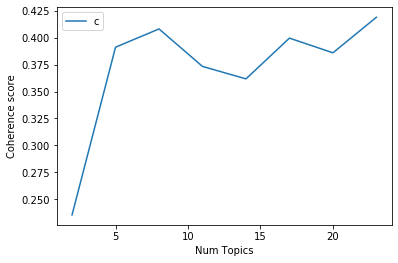

In [0]:
limit=25; start=2; step=3;
model_list, coherence_values = compute_coherence_values(dictionary=gensim_dict, corpus=corpus, texts=documents, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Voy a tomar el 8 como valor óptimo

In [0]:
#Modelo LDA
k=8    
lda_model = models.LdaModel(corpus, id2word=gensim_dict, num_topics=k, iterations=5, passes=20, alpha='auto')

Visualizo el modelo

In [0]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, gensim_dict)
pyLDAvis.display(vis)

Topic 1: Se habla de Corea del Norte, Rusia, fronteras. Se puede asociar más a Trump

Topic 2: Temas económicos y progreso. Podría asociarse a Obama

Topic 3: Nominación de Garland para la Supreme Court. Asociado con Obama

Topic 4: Fake News. Asociado a Trump

Topic 5: Salud, obamacare. Asociado a Obama

Topic 6: Felicitaciones, bienvenida a la Casa Blanca. Asociado a Trump

Topic 7: Salud, obamacare. Asociado a Obama

Topic 8: Clima, ataque terrorista Londrés

### 2.4.2.-Análisis de Topics de Obama

Primero preparo el dataset

In [0]:
#Filtro el dataset original por la label Obama

twitters_obama = twitters[ twitters['label']=='OBAMA']

documents_obama = []

for row in twitters_obama.iterrows():   #va recorriendo todas las filas del df
    _,info = row          #en info se queda con el Sendador, Answer y Respuesta. No se queda con el índice (_)         
    _,tweet = info
    tweet = re.sub(r'\n', '', tweet)
    #tokenizo 
    tweet = [t.text for t in nlp(tweet.rstrip(), disable=['parser', 'tagger', 'ner'])]
    #Lo juntamos todo en un mismo corpus
    documents_obama.append(tweet)

In [0]:
#Crea el vocabulario/diccionario 
gensim_dict_obama = Dictionary(documents_obama)
len(gensim_dict_obama)  

3550

In [0]:
corpus_obama = [gensim_dict_obama.doc2bow(doc) for doc in documents_obama]

Calculo el número óptimo de topics para Obama




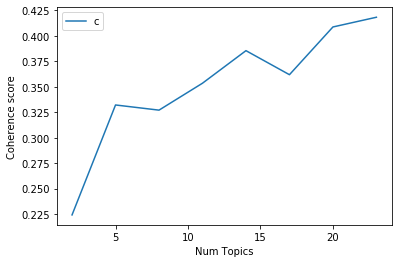

In [0]:
limit=25; start=2; step=3;
model_list, coherence_values = compute_coherence_values(dictionary=gensim_dict_obama, corpus=corpus_obama, texts=documents_obama, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Aunque sigue creciendo voy a escoger 6 como número óptimo para no complicarlo demasiado

In [0]:
#Modelo LDA
k=6    
lda_model = models.LdaModel(corpus_obama, id2word=gensim_dict_obama, num_topics=k, iterations=5, passes=20, alpha='auto')

In [0]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus_obama, gensim_dict_obama)
pyLDAvis.display(vis)

Aquí podemos ver los temas de los que habla Obama. 
- el Topic 1 es más confuso y no consigo extraer temática clara

- el Topic 2 parece que tiene que ver con inmigración, trabajo y economía

- el Topic 3 habla de Salud, cobertura sanitaria y Obamacare. 

- el Topic 4 habla de la nominación de Garland para la Supreme Court.

- el Topic 5 habla de lucha contra el cambio climático

- el Topic 6 me parece también confuso. Por un lado hay palabras que tienen que ver con el senado y la nominación a la corte suprema y por otro palabras que tienen que ver con la defensa de los homosexuales

### 2.4.2.-Análisis de Topics de Trump

In [0]:
#Filtro el dataset original por la label Trump

twitters_trump = twitters[ twitters['label']=='TRUMP']

documents_trump = []

for row in twitters_trump.iterrows():   #va recorriendo todas las filas del df
    _,info = row          #en info se queda con el Sendador, Answer y Respuesta. No se queda con el índice (_)         
    _,tweet = info
    tweet = re.sub(r'\n', '', tweet)
    #tokenizo 
    tweet = [t.text for t in nlp(tweet.rstrip(), disable=['parser', 'tagger', 'ner'])]
    #Lo juntamos todo en un mismo corpus
    documents_trump.append(tweet)

In [0]:
#Crea el vocabulario/diccionario 
gensim_dict_trump = Dictionary(documents_trump)
len(gensim_dict_trump) 

5577

In [0]:
corpus_trump = [gensim_dict_trump.doc2bow(doc) for doc in documents_trump]

Calculo el número óptimo de topics para Trump

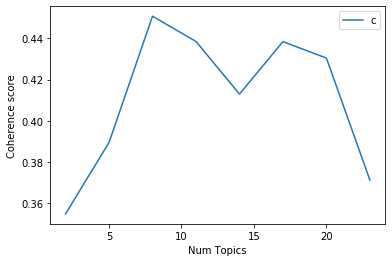

In [0]:
limit=25; start=2; step=3;
model_list, coherence_values = compute_coherence_values(dictionary=gensim_dict_trump, corpus=corpus_trump, texts=documents_trump, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Escojo como valor óptimo 8

In [0]:
#Modelo LDA
k=8    
lda_model = models.LdaModel(corpus_trump, id2word=gensim_dict_trump, num_topics=k, iterations=5, passes=20, alpha='auto')

In [0]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus_trump, gensim_dict_trump)
pyLDAvis.display(vis)

En cuanto a Trump podemos ver que habla de:

- Topic 1: Parece tener que ver con las relaciones con Corea del Norte y China

- Topic 2: El famoso "make america great again". Aparece también el tema de las fronteras, muro

- Topic 3: Habla sobre el triunfo en las elecciones y la llegada a la Casa Blanca

- Topic 4: Fake News

- Topic 5: Honor, nación

- Topic 6: Habla sobre la campaña en su contra por el tema de la influencia rusa en las elecciones

- Topic 7: Aparece el nombre de James Comey al que Trump despido como director del FBI

- Topic 8: Condolencias por el ataque terrorista en Londres

# 3.- Tweet Generation

Para la generación de texto en forma de tweet voy a utilizar Languaje Modeling con una arquitectura RNN

## 3.1.- Librerias

In [0]:
import spacy
import numpy as np

import pickle
import json
import os
import csv
import pprint as pp
import re

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from random import shuffle, choice, sample

from sklearn.model_selection import StratifiedShuffleSplit

from copy import copy
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

nlp = spacy.load('en_core_web_sm')

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display

sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from keras.models import Model, Sequential
from keras.layers import Input, CuDNNLSTM, Dense, LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import Dot, Concatenate, Flatten, Permute, Multiply, dot, concatenate
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras.preprocessing import sequence
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras.models import load_model

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.


## 3.2. Carga de datos

Cargo el fichero json. El nombre del fichero es **datset_2.json**

In [1]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dataset_2.json to dataset_2.json
User uploaded file "dataset_2.json" with length 1070528 bytes


In [10]:
twitters = pd.read_json('dataset_2.json', orient='index')
twitters.head(5)

,label,tweet
0,OBAMA,"“Low plastic stool, cheap but delicious noodle..."
1,OBAMA,"“Low plastic stool, cheap but delicious noodle..."
10,OBAMA,Michelle and I are so inspired by all the youn...
100,OBAMA,Senate leaders' obstruction of our Supreme Cou...
1000,OBAMA,"In 31 states, people can still be fired becaus..."


Voy a intentar generar mensajes escogiendo a **Trump** por tanto filtro el dataset y me quedo solo con los tweet de Trump

In [11]:
twitters_trump = twitters[twitters['label'] == 'TRUMP']
twitters_trump

,label,tweet
2894,TRUMP,My thoughts and prayers are with the families ...
2895,TRUMP,My thoughts and prayers are with the families ...
2896,TRUMP,I am heading for Canada and the G-7 for talks ...
2897,TRUMP,Congratulations to the Washington Capitals on ...
2898,TRUMP,Looking forward to straightening out unfair Tr...
...,...,...
5884,TRUMP,...vast sums of money to NATO &amp; the United...
5885,TRUMP,Despite what you have heard from the FAKE NEWS...
5886,TRUMP,Great meeting with the @RepublicanStudy Commit...
5887,TRUMP,"""The President Changed. So Has Small Businesse..."


## 3.3. Preprocesado de datos

- Veo que hay URLs.  Las URLs no me aportan información así que las voy a eliminar. Utilizo para ello una expresión regular

In [0]:
twitters_trump['twitter_procesado'] = twitters_trump['tweet'].apply (lambda t: re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', t))

- Veo que hay frases que contienen "....". Cuando me encuentro más de dos . seguidos los sustituyo por " "

In [0]:
twitters_trump['twitter_procesado'] = twitters_trump['twitter_procesado'].apply(lambda t: re.sub(r'\.{2,}', ' ', t))

- Si me encuentro varios espacios seguidos lo sustituyo por uno solo

In [0]:
twitters_trump['twitter_procesado'] = twitters_trump['twitter_procesado'].apply(lambda t: re.sub(r'\s+', ' ', t))

- Voy a comprobar si hay algún tweet con valor nan o vacío para eliminarlo si es así

In [0]:
twitters_trump.dropna(subset=['tweet'], inplace=True)
twitters_trump = twitters_trump.loc[twitters_trump['twitter_procesado']!='']

Preparo el dataset

In [33]:
trump_dataset = list()
for index, row in twitters_trump.iterrows():
    if index > 0:
        sentence = row[2].replace('\n', ' ') #aprovecho para quitar los caracteres \n
        trump_dataset.append(sentence)

#len(trump_dataset), trump_dataset[0] #Para ver un ejemplo
print ("Tengo " + str (len(trump_dataset)) + " frases")

Tengo 2991 frases


Tokenizo por caracteres

In [0]:
tokenized = [list(x) for x in trump_dataset]  #por caracter

In [0]:
init_chars = [x[:5] for x in tokenized] # me quedo con los 4 caracteres iniciales

for i in range(len(init_chars)):
    tmp = init_chars[i]
    tmp.insert(0, '<SOS>')
    init_chars[i] = tmp[:5]

In [36]:
#Miro la longitud de mis frases
maxlen = max([len(x) for x in tokenized])
avglen = sum([len(x) for x in tokenized]) / len(tokenized)
print ("La máxima longitud de las frases es: " + str(maxlen) + ". La media de la longitud es " + str(avglen))

La máxima longitud de las frases es: 314. La media de la longitud es 151.7703109327984


In [37]:
#Total de tokens
total_tokens = [t for s in trump_dataset for t in s]
len(total_tokens)

453945

Obtengo el vocabulario

In [38]:
#Vocabulario
vocab_counter = Counter(total_tokens)  #Cuenta los caracteres
vocab = [w for w, v in vocab_counter.items() if v>2] # filtrado de caracteres que minimo hayan aparecido 2 veces
vocab = ['<PAD>', '<UNK>', '<SOS>', '<EOS>', '<URL>'] + vocab #Le añadimos al vocabulario 5 tokens especiales

nb_vocab = len(vocab)
nb_vocab

110

In [0]:
c2id = {k: i for i, k in enumerate(vocab)}
id2c = {i: k for k, i in c2id.items()}

In [40]:
maxlen = 5
step = 1
data_train = []

#para cada frase le inserto al principio un <EOS> y le añado al final un <SOS>
for x in tokenized: # x es una lista con mi frase "tokenizada"
    x.insert(0, '<SOS>')
    x.append('<EOS>')
    #genero el dataset
    for i in range(0, len(x)-maxlen, step):
        data_train.append((x[i:i+maxlen], x[i+maxlen]))

len(data_train)

444972

In [0]:
SAMPLE_EVERY = 4

##3.4.- Helper functions

In [0]:
#para ganar diversidad
def sample_pred(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [0]:
class Sampletest(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % SAMPLE_EVERY == 0  and epoch>0:
            data_test = []
            nb_samples = 1
            
            params = {
                'maxlen': maxlen,
                'vocab': len(vocab),
                'use_embeddings': True
                }
            for _ in range(nb_samples):
                data_test = choice(init_chars)
                for diversity in [0.2, 0.6, 1.2]:
                    print('----- diversity:', diversity)
                    sentence = copy(data_test)
                    generated = copy(data_test)
                    for i in range(len(data_test), 400):
                        x_pred = np.zeros((1, params['maxlen']))
                        for t, char in enumerate(sentence):
                            x_pred[0, t] = c2id[char] if char in c2id else c2id['<UNK>']
                        preds = self.model.predict(x_pred, verbose=0)[0]
                        next_index = sample_pred(preds, diversity)
                        next_char = id2c[next_index]
                        if next_char == '<EOS>':
                            break
                        generated += [next_char]
                        sentence = sentence[1:] 
                        sentence += [next_char]
                    print(''.join(generated))


In [0]:
class HistoryDisplay(Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accs = []
        self.epochs = []
        self.fig, self.ax = plt.subplots()
        #plt.show()
        
        plt.ion()
        self.fig.show()
        self.fig.canvas.draw()
    
    def on_epoch_end(self, epoch, logs):
        self.epochs.append(epoch)
        self.losses.append(logs['loss'])
        self.accs.append(logs['acc'])
        if epoch % PLOT_EVERY == 0:
            
            self.ax.clear()
            self.ax.plot(self.epochs, self.accs, 'g', label='acc')
            self.ax.plot(self.epochs, self.losses, 'b', label='loss')
            legend = self.ax.legend(loc='upper right', shadow=True, fontsize='x-large')
            #display.clear_output(wait=True)
            #display.display(pl.gcf())
            self.fig.canvas.draw()
            
            #plt.draw()
        

In [0]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

## 3.5.-  Arquitectura y preparación de train y predict

In [0]:
class LM:
    def __init__(self, **kwargs):
        self.params = kwargs.pop('params', None)
        
    def compile_model(self, params={}):

        lm_inputs = Input(shape=(params['maxlen'], ), name='lm_input')  #Capa de entrada
        embedding = Embedding(params['vocab'], params['emb_feats'])(lm_inputs)  #Capa de Embedding
        
        #Utilizo como tipo de RNN: CuDNNLSTM
        lstm = CuDNNLSTM(params['rnn_hidden'], return_sequences=True, name='rnn1')
        
        lmlstm = Bidirectional(lstm)(embedding)
        
        stacklstm = CuDNNLSTM(params['rnn_hidden'], return_sequences=False, name='stack')
        stackedlstm = stacklstm(lmlstm)

        out = Dense(params['vocab'], activation='softmax')(stackedlstm)

        model = Model(lm_inputs, out)
        model.compile(
            optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        model.summary()
        return model
        
        
    def train(self, model, data, params={}):
        #uso los callbacks
        callbacks = self._get_callbacks()

        #hago uso de shuffle de los datos
        if 'shuffle' in params and params['shuffle']: #Si existe en el diccionario y es true
            shuffle(data)

        sentences, next_chars = zip(*data)
        x = np.zeros((len(data), params['maxlen']))
        y = np.zeros((len(data), params['vocab']))
        for i, sentence in enumerate(sentences):
            for t, char in enumerate(sentence):
                x[i, t] = c2id[char] if char in c2id else c2id['<UNK>']
            y[i, c2id[next_chars[i]] if next_chars[i] in c2id else c2id['<UNK>']] = 1

        model.fit(x, y, validation_split=0.2, batch_size=params['batch_size'], epochs=params['epochs'], callbacks=callbacks, verbose=1)
        
    def predict(self, model, data, params={}): 
        for diversity in [0.2, 0.6, 1.2]:
            print('------ diversity: ', diversity)
            sentence = copy(data)  
            generated = copy(data)
            for i in range(len(data), 240): 
                x_pred = np.zeros((1, params['maxlen'])) 
                for t, char in enumerate(sentence):
                    x_pred[0, t] = c2id[char] if char in c2id else c2id['<UNK>'] 
                
                preds = self.model.predict(x_pred, verbose=0)[0] 
                next_index = sample_pred(preds, diversity) 
                next_char = id2c[next_index] 

                if next_char == '<EOS>':
                    break
                
                generated += [next_char] 
                sentence = sentence[1:] 
                sentence+= [next_char]
            
            print(''.join(generated))

   #Callback de Keras     
    def _get_callbacks(self, model_path='model_lm.h5'):
        #monitorizamos para para el entrenamiento y nos tenemos que fijar en val_loss. 
        #Si en la 4 época consecutiva la val_loss no baja el entreno para
        es = EarlyStopping(monitor='val_loss', patience=4, mode='auto', verbose=0)

        #Cuando baja guarda una copia del modelo. Podemos quedarnos con el mejor o diferentes
        #y le indicamos si guardamos los pesos o el modelo entero con una periodicidad de 2
        save_best = ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, period=2)
        
        #Nos reduce el learning rate con el factor 0,2 si durante 3 epochs la val_loss no ha bajado
        #Cuando llegue a lr=0.0001 no lo reduce más
        rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)
        st = Sampletest()
        hd = HistoryDisplay()
        return [st, rlr, es]

## 3.6.-  Compilar

In [0]:
compile_params = {
    'maxlen': maxlen,
    'vocab': len(vocab),
    'emb_feats': 100,
    'rnn_hidden': 256
}

In [48]:
lm = LM()

lm_model = lm.compile_model(params=compile_params)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lm_input (InputLayer)        (None, 5)                 0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 5, 100)            11000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 5, 512)            733184    
_________________________________________________________________
stack (CuDNNLSTM)            (None, 256)               788480    
_________________________________________________________________
dense_2 (Dense)              (None, 110)               28270     
Total params: 1,560,934
Trainable params: 1,560,934
Non-trainable params: 0
_________________________________________________________________


## 3.7.-  Entrenar

In [0]:
train_params = {
    'epochs': 500,
    'batch_size': 512,
    'shuffle': True,
    'vocab': len(vocab),
    'maxlen': maxlen,
}

In [50]:
lm.train(lm_model, data=data_train, params=train_params)

Train on 355977 samples, validate on 88995 samples
Epoch 1/500
355977/355977 [==============================] - 9s 25us/step - loss: 2.5656 - acc: 0.3026 - val_loss: 2.2031 - val_acc: 0.3812
Epoch 2/500
355977/355977 [==============================] - 8s 23us/step - loss: 1.9927 - acc: 0.4507 - val_loss: 1.8605 - val_acc: 0.4878
Epoch 3/500
355977/355977 [==============================] - 8s 24us/step - loss: 1.7269 - acc: 0.5262 - val_loss: 1.6845 - val_acc: 0.5388
Epoch 4/500
355977/355977 [==============================] - 8s 24us/step - loss: 1.5710 - acc: 0.5657 - val_loss: 1.5920 - val_acc: 0.5616
Epoch 5/500
355977/355977 [==============================] - 8s 24us/step - loss: 1.4688 - acc: 0.5918 - val_loss: 1.5210 - val_acc: 0.5783
----- diversity: 0.2
<SOS>Image and the people of the Working for the political and the Democrats and they want to be a listen Theresa May to be they are with they were because to be a big deal of the work to the Council many to our country and doin

## 3.8.-  Prueba de generación de tweets

In [53]:
data_test = []
nb_samples = 5

params = {
    'maxlen': maxlen,
    'vocab': len(vocab),
    'use_embeddings': True
    }

for _ in range(nb_samples):
    data_test = choice(init_chars)
    
    for diversity in [0.2, 0.4, 0.6]:
        print('----- diversity:', diversity)
        sentence = copy(data_test)
        generated = copy(data_test)
        for i in range(len(data_test), 400):
            x_pred = np.zeros((1, params['maxlen']))
            for t, char in enumerate(sentence):
                x_pred[0, t] = c2id[char] if char in c2id else c2id['<UNK>']
            preds = lm_model.predict(x_pred, verbose=0)[0]
            next_index = sample_pred(preds, diversity)
            next_char = id2c[next_index]
            if next_char == '<EOS>':
                break
            generated += [next_char]
            sentence = sentence[1:] 
            sentence += [next_char]
        tweet = ''.join(generated)
        print(tweet[5:])    

----- diversity: 0.2
Today, it was a great honor to welcome Prime Minister Theresa May to offer condolences on the terrorist attack in London. She is strong and the Fake News Media is a total disaster Theresa May today today to offer condolences on the terrorist attack in London. She is strong and the terrorist attack in London. She is strong and the terrorist attack in London. She is strong and we will be a great ho
----- diversity: 0.4
Today, I said so much more that the Republicans in the Fake News is a truly great honor to watching to the U.S. and the United States through the people of the single really interviewed by the terrorist attack in London. She is strong and security of our Country is a totally going very well.
----- diversity: 0.6
Today to the worked coverage and the courage of the entire Nation. The United State &amp; deductive in the workers!
----- diversity: 0.2
Congress to the U.S. history of the terrorist attack in London. She is strong and the U.S. has been a compa